In [150]:
from reverting import *
import matplotlib.pyplot as plt 
%matplotlib inline
%load_ext autoreload
%autoreload 2
from IPython.display import clear_output
import os 
import numpy as np 
from matplotlib import cm
from matplotlib import rc
rc('text', usetex=True)
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [151]:
# run a simulation with trial i and l = 5 particle diameters

In [ ]:
for p in param:
    S = simulate(param,tmax=3600*2500) # run the simulation for 500 hr 
    np.save('../simulations/flow_i-l_2.199-time_2500hr-rate_5Hz',S)

In [ ]:
# tmax is in seconds. This is a simulation for flow condition i.
# 1 hr of simulation takes just under 20s
# 180 hr of virtual time (180*3600 sec) expected to take about an hr 
t0 = time.time()
S = simulate(param,tmax=3600*2500) # run the simulation for 500 hr 
np.save('../simulations/flow_i-l_2.199-time_2500hr-rate_5Hz',S)
print('simulation required ' + str((time.time()-t0)/3600) + ' hours to finish')

1 hour(s) simulated
2 hour(s) simulated
3 hour(s) simulated
4 hour(s) simulated
5 hour(s) simulated
6 hour(s) simulated
7 hour(s) simulated
8 hour(s) simulated
9 hour(s) simulated
10 hour(s) simulated
11 hour(s) simulated
12 hour(s) simulated
13 hour(s) simulated
14 hour(s) simulated


In [36]:
# load in simulation results to try to get distribution of resting times 
S = np.load('../simulations/flow_i-l_2.199-time_500hr-rate_5Hz.npy')
n,m,t = S

In [37]:
def rt_cdf_marginal(t,m,mstar,dt):
    """compute the return time distribution marginal to (integer) elevation mstar given a time series of transitions t
    and a series m(t) of bed elevations across this time series"""
    departures, = np.where( (np.roll(m,1) <= mstar) & (m > mstar) ) # indices of depature from mstar
    returns, = np.where( (np.roll(m,1) > mstar) & (m <= mstar)  ) # indices of return to mstar
    # must start from a departure
    while returns.min()<departures.min():
        returns = returns[1:]
    # must end at a return
    while returns.max()<departures.max():
        departures = departures[:-1]
    # compute the return times    
    rt = t[returns] - t[departures] 
    # generate a return time distribution to elevation mstar from above
    bins = np.arange(0,3600*3, dt)
    H,bins = np.histogram( rt , bins = bins, normed = True )
    dx = bins[1] - bins[0] # bin size 
    F = 1-np.cumsum(H)*dx # cumulative distribution of return time 
    return F  

In [38]:
def rt_unconditional(t,m,dt=3.0,dm=5):
    """compute the unconditional return time from above of the bed elevation time series
    dt is the time resolution... suggested 5.0s 
    dm is the space resolution... suggested 5 (particles)
    t is the times at which bed elevations change
    m is the time series of bed elevation values at these times
    """
    mmin = round(m.mean()-3*m.std()) # the minimum m value to include 
    mmax = round(m.mean()+3*m.std()) # the range of m values to include into the computation of the resting time cdf 
    #dm = 5  # the interval between m values to discretize bed elevations over 
    mvals = np.arange(mmin,mmax+dm,dm) # the set of values of m over which to calculate the pdf of bed elevations 
    pm,_ = np.histogram(m,bins=mvals, normed=True)    # the pdf of bed elevations 
    pm=pm*dm # pdf of bed elevations
    mvals = np.arange(mmin,mmax,dm) # the set of m values over which the bed elevation pdf is known
    bins = np.arange(0,3600*3, dt)
    pTm = np.array([rt_cdf_marginal(t,m,mv,dt) for mv in mvals]) # marginal cdf of return time from above across elevations
    cdf = (pTm*pm.reshape(-1,1)).sum(axis=0)  # cumulative resting time distribution -- convolve all bed elevations like Yang and Sayre or Nakagawa Tsujimoto 
    # or Voepel and Hassan 
    return bins[1:],cdf # return times t and cumulative distribution P(T>t) 

In [39]:
T,F = rt_unconditional(t,m)

/home/kp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  if sys.path[0] == '':
/home/kp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  app.launch_new_instance()


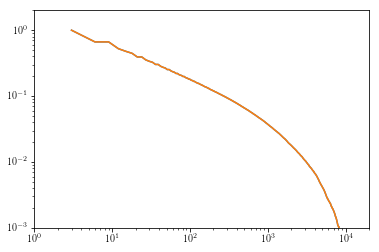

In [41]:
plt.loglog(TT,FF)
plt.ylim(1e-3,2)
plt.xlim(1,2e4)
plt.loglog(T,F)

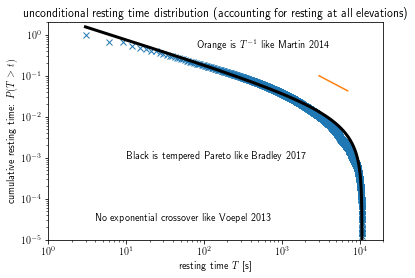

In [149]:
# tt = T[(T>3e3) & (T<7e3)]
def power(tt,a=1.0,x1=3e3,y1=1e-1):
    x1,y1 = 3e3, 1e-1 # point it passes thru
    A = y1*x1**a
    y = A*tt**(-a)
    return y

plt.loglog(T,F,'x')
plt.loglog(tt,power(tt))
plt.loglog(T,pareto(T,a=3,b=1.07e4,c=0.6),color='black',lw=3)
plt.ylim(1e-5,2)
plt.xlim(1,2e4)
plt.ylabel('cumulative resting time: $P(T>t)$')
plt.xlabel('resting time $T$ [s]')
plt.text(1e1,1e-3,'Black is tempered Pareto like Bradley 2017')
plt.text(8e1,5e-1, 'Orange is $T^{-1}$ like Martin 2014')
plt.text(4e0,3e-5,'No exponential crossover like Voepel 2013')
plt.title(' unconditional resting time distribution (accounting for resting at all elevations)')
plt.savefig('/home/kp/Desktop/temperedpareto.png')

In [64]:
def pareto(x,a=3.0,b=1.1e4,c=0.56):
    return a*(x**(-c)-b**(-c))/(1-(a/b)**c)